In [1]:
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
 

In [2]:
# Function to load data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
 
# Function to extract features from user data in batches
def extract_features(trainOrTest,data, tweets_tensor_path, batch_size=64):
    features = []
    labels = []
    tweet_index=0
    if(trainOrTest=="test"):
        tweet_index=8277
    # Load tweet embeddings tensor from the file
    tweets_tensor = torch.load(tweets_tensor_path)
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]


        for j, user in enumerate(batch):
            verified = 1 if user['profile']['verified'] == 'True ' else 0
            protected = 1 if user['profile']['protected'] == 'True ' else 0
            geo_enabled = 1 if user['profile']['geo_enabled'] == 'True ' else 0

            followers_count = int(user['profile']['followers_count'])
            friends_count = int(user['profile']['friends_count'])
            listed_count = int(user['profile']['listed_count'])
            favourites_count = int(user['profile']['favourites_count'])
            statuses_count = int(user['profile']['statuses_count'])

            tweets_emb = tweets_tensor[tweet_index + i + j].cpu().numpy()  # Correctly index into tweets_tensor

            user_features = np.concatenate([
                [verified, protected, geo_enabled],
                [followers_count, friends_count, listed_count, favourites_count, statuses_count],
                tweets_emb
            ])
            features.append(user_features)
            labels.append(int(user.get('label', 0)))  # Label information

        torch.cuda.empty_cache()

    return np.array(features), np.array(labels)

def getFollowerFollowing(data):
    follower_following = []
    user_ids =[]
    for entry in data:
        user_id = entry['ID']
        user_ids.append(user_id)
        
        if 'neighbor' in entry and entry['neighbor'] is not None:
            following = entry['neighbor'].get('following', [])
            follower_following.extend([(user_id, neighbor) for neighbor in following])
    return follower_following
        
    

In [3]:
 # Load and process data
train_data = load_data('train.json')
test_data = load_data('test.json')
train_features, train_labels = extract_features("train",train_data,"tweets_tensor.pt")
test_features, test_labels = extract_features("test",test_data,"tweets_tensor.pt")
follower_following = getFollowerFollowing(train_data)

# Scale numeric features
scaler = MinMaxScaler()
scaler_tweet = StandardScaler()

#followers_count, friends_count, listed_count, favourites_count, statuses_count
numeric_features_train = train_features[:, 3:8]
scaled_numeric_train = scaler.fit_transform(numeric_features_train)
#test
numeric_features_test = test_features[:, 3:8]
scaled_numeric_test = scaler.fit_transform(numeric_features_test)

# verified, protected, geo_enabled
non_numeric_features=train_features[:, :3]
#test
non_numeric_features_test=test_features[:, :3]

# 768 dimension of tweet embeddings
tweet_embeddings = train_features[:, 8:]
#test
tweet_embeddings_test = test_features[:, 8:]


tweet_embeddings_scaled = scaler_tweet.fit_transform(tweet_embeddings)
#test
tweet_embeddings_scaled_test = scaler_tweet.fit_transform(tweet_embeddings_test)

pca = PCA(n_components=100)  # Example: Reduce to 100 dimensions
tweet_embeddings_reduced = pca.fit_transform(tweet_embeddings_scaled)
#test
tweet_embeddings_reduced_test = pca.fit_transform(tweet_embeddings_scaled_test)
train_features = np.hstack((non_numeric_features,scaled_numeric_train,tweet_embeddings_reduced))
test_features = np.hstack((non_numeric_features_test,scaled_numeric_test,tweet_embeddings_reduced_test))


In [4]:
# Create a train_train_train_train_train_train_train_train_graph
user_ids = [user['ID'] for user in train_data]
user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
filtered_edges = [(follower, following) for follower, following in follower_following if follower in user_ids and following in user_ids]
#follower_following = [(user_id_map[user['ID']], user_id_map[neighbor]) for user in train_data if user.get('neighbor') for neighbor in user['neighbor'].get('following', []) if neighbor in user_id_map]

In [5]:
# create combined graph for train and test 
combined_data = train_data + test_data
combined_user_ids = [user['ID'] for user in combined_data]
combined_follower_following = getFollowerFollowing(combined_data)
combined_filtered_edges = [(follower, following) for follower, following in combined_follower_following if follower in combined_user_ids and following in combined_user_ids]

# Construct the graph
combined_graph = nx.Graph()
combined_graph.add_nodes_from(combined_user_ids)
combined_graph.add_edges_from(combined_filtered_edges)
# Verify the number of nodes and edges
print("Number of nodes:", combined_graph.number_of_nodes())
print("Number of edges:", combined_graph.number_of_edges())

Number of nodes: 9461
Number of edges: 7664


In [6]:
# Construct the train_graph
train_graph = nx.Graph()
train_graph.add_nodes_from(user_ids)
train_graph.add_edges_from(filtered_edges)
 
# Verify the number of nodes and edges
print("Number of nodes:", train_graph.number_of_nodes())
print("Number of edges:", train_graph.number_of_edges())

Number of nodes: 8278
Number of edges: 5846


In [7]:
test_user_ids = [user['ID'] for user in test_data]
test_follower_following = getFollowerFollowing(test_data)
test_filtered_edges = [(follower, following) for follower, following in test_follower_following if follower in test_user_ids and following in test_user_ids]
# Construct the test_graph
test_graph = nx.Graph()
test_graph.add_nodes_from(test_user_ids)
test_graph.add_edges_from(test_filtered_edges)

# Verify the number of nodes and edges
print("Number of nodes:", test_graph.number_of_nodes())
print("Number of edges:", test_graph.number_of_edges())


Number of nodes: 1183
Number of edges: 116


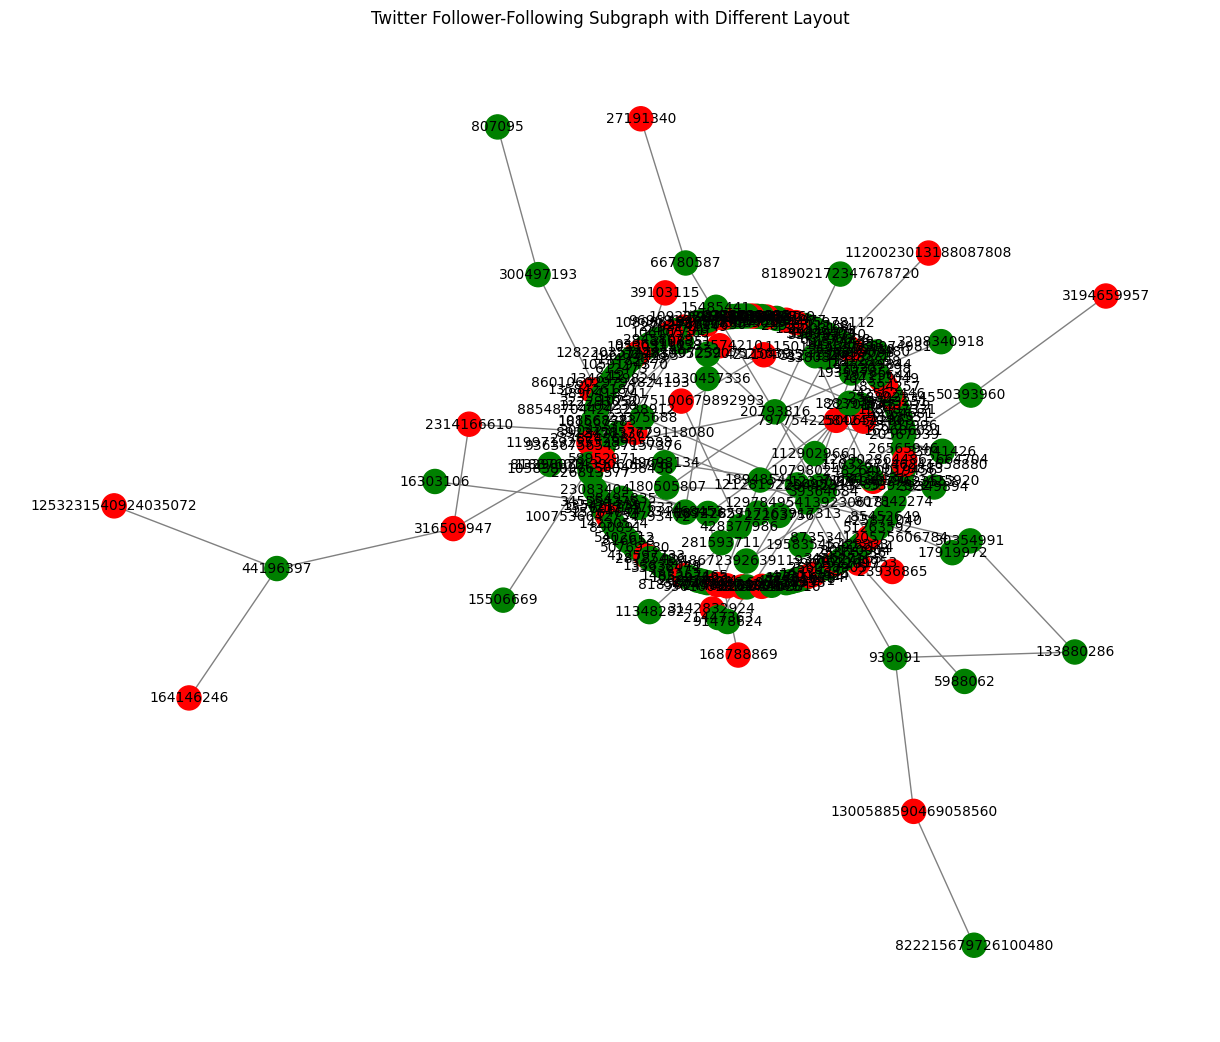

In [8]:
# Alternatively, filter nodes with the highest degree centrality
degree_centrality = nx.degree_centrality(train_graph)
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:200]
subgraph = train_graph.subgraph(top_nodes)
# Create a color map for nodes
color_map = []
for node in subgraph:

    if (train_labels[user_ids.index(node)] == 1):
        color_map.append('red')
    else:
        color_map.append('green')

plt.figure(figsize=(12, 10))
#pos = nx.spring_layout(subgraph)  # Fruchterman-Reingold force-directed algorithm
pos = nx.kamada_kawai_layout(subgraph)  # Kamada-Kawai layout algorithm
#pos = nx.circular_layout(subgraph)  # Circular layout

nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color=color_map, font_size=10, font_color='black', edge_color='gray')
plt.title('Twitter Follower-Following Subgraph with Different Layout')
plt.show()



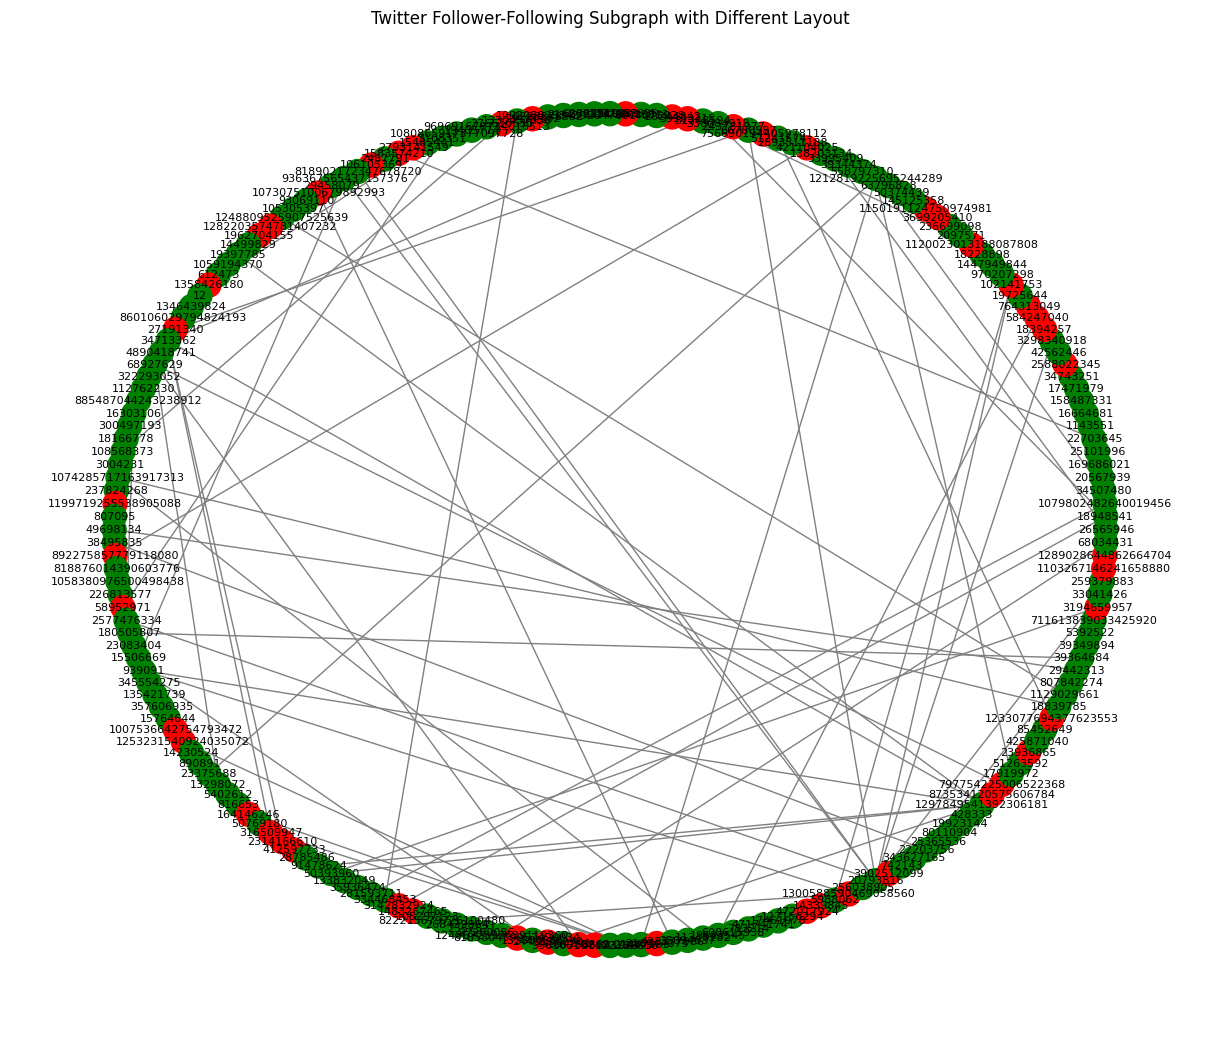

In [9]:

plt.figure(figsize=(12, 10))
pos = nx.circular_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color=color_map, font_size=8, font_color='black', edge_color='gray')
plt.title('Twitter Follower-Following Subgraph with Different Layout')
plt.show()

Using node2vec can be a valuable addition to approach, captures more sophisticated node embeddings that incorporate both structural and feature-based information about nodes in your graph. node2vec generates node embeddings that reflect the graph's topology, which can then be combined with existing feature vectors for each user.

In [10]:
from node2vec import Node2Vec
node2vec = Node2Vec(combined_graph, dimensions=32, walk_length=8, num_walks=100, workers=8, p=1, q=1)
model = node2vec.fit(window=4, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/9461 [00:00<?, ?it/s]

In [11]:
# Get embeddings for each node
node_embeddings = {str(node): model.wv[str(node)] for node in combined_graph.nodes()}

# Extract node embeddings for training nodes
train_node_embeddings = np.array([node_embeddings[str(node)] for node in train_graph.nodes()])

# Extract node embeddings for test nodes
test_node_embeddings = np.array([node_embeddings[str(node)] for node in test_graph.nodes()])


In [12]:
# Combine training features
combined_train_features = np.hstack(( scaled_numeric_train,non_numeric_features, train_node_embeddings,tweet_embeddings_reduced))

# Combine test features
combined_test_features = np.hstack(( scaled_numeric_test,non_numeric_features_test, test_node_embeddings,tweet_embeddings_reduced_test))

In [13]:
# Create a mapping from user IDs to numerical indices TRAIN
train_user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
# Create a mapping from user IDs to numerical indices TEST
test_user_id_map = {user_id: idx for idx, user_id in enumerate(test_user_ids)}

# Convert edges to numerical indices
train_edges = [(train_user_id_map[str(src)], train_user_id_map[str(dst)]) for src, dst in train_graph.edges()]
test_edges = [(test_user_id_map[str(src)], test_user_id_map[str(dst)]) for src, dst in test_graph.edges()]
# Convert the edges to a PyTorch tensor
train_edge_index = torch.tensor(train_edges, dtype=torch.long).t().contiguous()
test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

In [14]:
# Convert to PyTorch Geometric data format
train_data = Data(x=torch.tensor(combined_train_features, dtype=torch.float), edge_index=train_edge_index)
test_data = Data(x=torch.tensor(combined_test_features, dtype=torch.float), edge_index=test_edge_index)

# Convert labels to tensor and add to data object
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_data.y = train_labels
test_data.y = test_labels

In [15]:
# Define the GNN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [16]:
combined_train_features.shape[1]

140

In [17]:
# Initialize the model, loss function, and optimizer
model = GCN(in_channels=combined_train_features.shape[1], hidden_channels=32, out_channels=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training the GNN model
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing the GNN model
def test(data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum()
    acc = int(correct) / int(data.y.size(0))
    return acc

In [19]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    loss = train(train_data)
    train_acc = test(train_data)
    test_acc = test(test_data)
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.4575, Train Accuracy: 0.4909, Test Accuracy: 0.4954
Epoch: 002, Loss: 1.3903, Train Accuracy: 0.4953, Test Accuracy: 0.4945
Epoch: 003, Loss: 1.3266, Train Accuracy: 0.5043, Test Accuracy: 0.4937
Epoch: 004, Loss: 1.2665, Train Accuracy: 0.5086, Test Accuracy: 0.4954
Epoch: 005, Loss: 1.2102, Train Accuracy: 0.5145, Test Accuracy: 0.4937
Epoch: 006, Loss: 1.1578, Train Accuracy: 0.5228, Test Accuracy: 0.4945
Epoch: 007, Loss: 1.1093, Train Accuracy: 0.5281, Test Accuracy: 0.4877
Epoch: 008, Loss: 1.0646, Train Accuracy: 0.5388, Test Accuracy: 0.4886
Epoch: 009, Loss: 1.0239, Train Accuracy: 0.5449, Test Accuracy: 0.4894
Epoch: 010, Loss: 0.9869, Train Accuracy: 0.5515, Test Accuracy: 0.4861
Epoch: 011, Loss: 0.9536, Train Accuracy: 0.5593, Test Accuracy: 0.4903
Epoch: 012, Loss: 0.9237, Train Accuracy: 0.5687, Test Accuracy: 0.4920
Epoch: 013, Loss: 0.8972, Train Accuracy: 0.5750, Test Accuracy: 0.4937
Epoch: 014, Loss: 0.8735, Train Accuracy: 0.5808, Test Accuracy: